# Pytorch classifier notebook

V1 : only 1 split. First implementation  
All folds V1 : with all folds  
All folds V2 : add activation stats plot  
All folds V3 : try 2 outputs regression and classification. Activation stats plot fixed.  
All folds V4 : still 2 outputs regression and classification, but 2 variables on last layer, instead of 2 last layers.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.utils.tensorboard import SummaryWriter
import io
import PIL.Image

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

DATASET_INPUT_FILE = 'train.csv'

FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)]

# For custom non-overlaped folds generation
TRAIN_PERCENT = 0.70  
TEST_PERCENT = 0.30

#pd.set_option('display.max_rows', 500)

In [2]:
# Deterministic Behavior
seed = 42
#os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
#random.seed(seed)
# CuDA Determinism
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [101]:
#BATCH_SIZE = 50000
#BATCH_SIZE = 4096 # Gave once better results than 50000
#BATCH_SIZE = 2048

#BATCH_SIZE = 300000

#BATCH_SIZE = 500000
BATCH_SIZE = 100000

#BATCH_SIZE = 8192
#BATCH_SIZE = 40960

NUM_EPOCHS = 100
#MODEL_COMMENT = "All folds, 3 layers 2000, 1000 and 1, batch size 4096, lr=1e-4, patience 5, standard scale, 0.7 dropout, activ stats, CLASSIF+REG without sigmoid on reg"
MODEL_COMMENT = "All folds, 3 layers width 1300-1600, classif+reg, batch size 50000, lr=1e-3, patience 5, no standard scale, 0.3 dropout, activ stats, CLASSIF+REG 2 vars last layer, tanh, only reg used"

In [4]:
def pyStandardScale(tensor, mean, std):
    return((tensor - mean) / std)

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

from matplotlib.colors import ListedColormap
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv_indices_custom(cv_custom, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_custom):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [6]:
# This function accounts for variable instance counts in each split by dividing utility_pi by number of instances (but this has been removed)
# It also does some copy of dataframe to prevent memory overwrite
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]
    
    if (np.sqrt(df_test_utility_pi.pow(2).sum()) == 0):
        t = 0

    else:
        t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))
        
    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [7]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [8]:
class SaveOutputActivationStats:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        #self.outputs.append(module_out)
        self.outputs.append({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        
    def clear(self):
        self.outputs = []

In [9]:
#fig, ax = plt.subplots(1, 1)
#
#plot_cv_indices(cv, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20);

In [10]:
torch.device

torch.device

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.current_device()

0

In [13]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

# Load data

In [14]:
# Load data
    
df = pd.read_csv(DATASET_INPUT_FILE)
df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

print('Data loaded')


Data loaded


# Non overlap fold generation

In [15]:
date_indexes_list = df.groupby('date')['ts_id'].first().to_list()

In [16]:
base_train_split_size = int((df.shape[0] // 5) * TRAIN_PERCENT)

In [17]:
base_test_split_size = int((df.shape[0] // 5) * TEST_PERCENT)

In [18]:
train_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [19]:
test_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [20]:
train_split_start_indexes

[0, 477711, 958233, 1435933, 1913985]

In [21]:
df.shape[0] - 1

2390490

In [22]:
NB_FOLDS = 5
last_index = df.shape[0] - 1

cv_table = []

for fold_indice in range(NB_FOLDS):
    fold_train_start_index = train_split_start_indexes[fold_indice]
    
    if (fold_indice == NB_FOLDS - 1):    
        nextfold_train_start_index = last_index
        
    else:
        nextfold_train_start_index = train_split_start_indexes[fold_indice + 1]
    
    fold_test_start_index = take_closest(date_indexes_list, int(TRAIN_PERCENT * (nextfold_train_start_index - fold_train_start_index) + fold_train_start_index  ))
    
    cv_table.append(fold_train_start_index)
    cv_table.append(fold_test_start_index)

In [23]:
cv_table.append(last_index)

In [24]:
cv_tuples = []

for i in range(0, NB_FOLDS*2, 2):
    cv_tuples.append([df.loc[cv_table[i]:cv_table[i+1]-1, :].index.to_list(), df.loc[cv_table[i+1]:cv_table[i+2]-1, :].index.to_list()])

In [25]:
cv_tuples_generator = iter(cv_tuples)

In [26]:
#fig, ax = plt.subplots(1, 1)

#plot_cv_indices_custom(cv_tuples_generator, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20); 

#cv_tuples_generator = iter(cv_tuples)

In [27]:
# Size of training set :
#train_sets_table =  [cv_tuples[i][0] for i in range(5)]
#sum([len(train_set_table) for train_set_table in train_sets_table])

In [28]:
# Our old time series split (with overlap : required 1 neural network trained per split)
# But in this script it's not needed because we're training 1 unique network, with a different fold strategy (non overlaped)
#cv = PurgedGroupTimeSeriesSplit(
#    n_splits=5,
#    max_train_group_size=180,
#    group_gap=20,
#    max_test_group_size=60
#)

In [29]:
#train_index, test_index = next(cv.split(df, (df['resp'] > 0)*1, df['date']))

In [30]:
#(df.loc[train_index, 'resp'] > 0).astype(np.byte)

In [31]:
f_mean = df.loc[:, FEATURES_LIST_TOTRAIN].mean(axis=0)

In [32]:
f_mean.shape

(130,)

In [33]:
df.fillna(f_mean, inplace=True)

In [34]:
#print('Sum of model parameters:')
#[print(p.sum()) for p in model.parameters()]

In [35]:
#writer = SummaryWriter()

#writer.add_text('test', 'test:'  + str(model).replace('\n', '<BR>'))

#writer.flush()
#writer.close()

In [36]:
#str([p.numel() for p in model.parameters()])

In [37]:
folds_list = []

for fold, (train_index, test_index) in enumerate(cv_tuples_generator):
    folds_list.append((train_index, test_index))

In [38]:
folds_list_train = [folds_list[i][0] for i in range(5)]
folds_list_train_flat = [folds_list_train_item for sublist in folds_list_train for folds_list_train_item in sublist]
folds_list_train_unique = list(set(folds_list_train_flat))

In [39]:
len(folds_list_train_unique)

1677155

In [40]:
np.sum([len(folds_list_train_item) for folds_list_train_item in folds_list_train])

1677155

In [41]:
len(folds_list_train_flat)

1677155

In [42]:
folds_list_test = [folds_list[i][1] for i in range(5)]
folds_list_test_flat = [folds_list_test_item for sublist in folds_list_test for folds_list_test_item in sublist]
folds_list_test_unique = set(folds_list_test_flat)

In [43]:
np.sum([len(folds_list_test_item) for folds_list_test_item in folds_list_test])

713335

In [44]:
len(folds_list_test_flat)

713335

In [45]:
len(folds_list_train_flat) + len(folds_list_test_flat)

2390490

In [46]:
df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN].to_numpy().shape

(141980, 130)

In [47]:
df.shape

(2390491, 139)

# Training

In [ ]:
print('Training started')
patience=5

utility_scores = [None] * 5
accuracy_scores = [None] * 5

writer = SummaryWriter()

ts_train = torch.tensor(df.loc[folds_list_train_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')
ts_train_y_reg = torch.tensor(df.loc[folds_list_train_unique, 'resp'].to_numpy(), device='cuda')

# Normalize data
ts_train_mean = torch.mean(ts_train, axis=0)
ts_train_std = torch.std(ts_train, axis=0)
#ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y, ts_train_y_reg)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # pin_memory : VOIR RESULTAT

ts_test = [None] * 5
ts_test_y = [None] * 5    
ts_test_y_reg = [None] * 5   
test_dataset = [None] * 5
test_loader = [None] * 5

for fold_indice in range(5):
    ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')
    ts_test_y_reg[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], 'resp'].to_numpy(), device='cuda')

    # Normalize
    #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)
    
    test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice], ts_test_y_reg[fold_indice])
    test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE)

torch.manual_seed(seed)

'''
model = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),

        nn.Linear(200, 100),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),
    
        nn.Linear(100, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
'''

class MLP(torch.nn.Module):
    #def __init__(self, n_feature, n_hidden): 
    def __init__(self): 
        super(MLP, self).__init__() 

        #nn.Dropout(0.2),
        self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), 1300)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(1300, 600)
        #self.batchnorm2 = nn.BatchNorm1d(130)
        self.act2 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(600, 1)
        
        #self.layer11_classif = nn.Linear(30, 1)
        #self.act11_classif = nn.Sigmoid()  

        #self.layer11_reg = nn.Linear(30, 1)



    def forward(self, x):
        x = self.dropout1(self.act1(self.layer1(x)))
        x = self.dropout2(self.act2(self.layer2(x)))
        x = self.layer3(x)

        #x_out_classif = nn.Sigmoid()(x[:, 0]).unsqueeze(-1)
        #x_out_reg = x[:, 1].unsqueeze(-1)

        #x_out_classif = nn.Sigmoid()(x[:, 0])
        #x_out_reg = x[:, 1]
        x_out_reg = x

        #return x_out_classif, x_out_reg
        return x_out_reg

model = MLP().double().to('cuda')
print('Model created')

#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list

loss_fn = nn.BCELoss().to('cuda')
loss_fn_reg = nn.MSELoss().to('cuda')

#def MSE_SignedLoss(output, target):
    #return((nn.LeakyReLU()(-(output*target)) / torch.abs(output*target)) * loss_fn_reg(output, target))

def MSE_SignedLoss(output, target):
    return(
        torch.sqrt(
            torch.mean(
                (nn.LeakyReLU()(-(output*target)) / torch.abs(output*target)) * torch.pow(output - target, 2)
        )
    )
    )

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 

model.eval()
#start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
#start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
#print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
#print('Start Validation Utility: {:.4f}'.format(start_utility_score))

### Call back to save activation stats (mean, std dev and near 0 values after activation functions)

Val_Loss = 0
N_Samples = 0

the_last_loss = 100
the_last_utility_score = 0
the_last_accuracy = 0
trigger_times=0
early_stopping_met = False

for epoch in range(NUM_EPOCHS): 
    running_loss = 0.0        
    
    # Setting hook for activation layers stats
    hook_handles = []
    save_output_activation_stats = []

    for layer in model.modules():
        if ('activation' in str(type(layer))):
            save_output_activation_stats_1layer = SaveOutputActivationStats()
            handle = layer.register_forward_hook(save_output_activation_stats_1layer)
            save_output_activation_stats.append(save_output_activation_stats_1layer)
            hook_handles.append(handle)
    
    model.train()

    for batch in train_loader:
        #inputs, labels = batch[0], batch[1]
        inputs, labels, labels_reg = batch[0].to('cuda'), batch[1].to('cuda'), batch[2].to('cuda')
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            #outputs_classif, outputs_reg = model(inputs)
            outputs_reg = model(inputs)
            #loss_classif = loss_fn(outputs_classif.unsqueeze(-1), labels.unsqueeze(-1).double())
            loss_classif = 0
            #loss_reg = MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double()) * torch.tensor(864.625) # Coefficient to balance reg loss which is much smaller
            loss_reg = MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double()) # Coefficient to balance reg loss which is much smaller
            #loss_reg = loss_fn_reg(outputs_reg.unsqueeze(-1), labels_reg.unsqueeze(-1).double()) # Coefficient to balance reg loss which is much smaller
            
            #loss = loss_classif + loss_reg
            loss = loss_reg
            #loss = loss_classif
            
            loss.backward()
            optimizer.step()

    # update local train loss
        running_loss += loss.item() * inputs.size(0)

    # update global train loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

    writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

    # Write activation stats graphs
    for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
        df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

        fig, ax = plt.subplots(1, 3, figsize=(25, 4))

        ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
        ax[0].set_xlabel('Batch instances')
        ax[0].set_ylabel('Mean')
        ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

        ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
        ax[1].set_xlabel('Batch instances')
        ax[1].set_ylabel('Standard deviation')
        ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

        ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
        ax[2].set_xlabel('Batch instances')
        ax[2].set_ylabel('Percentage')
        ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);
        
        plot_buf = io.BytesIO()
        plt.savefig(plot_buf, format='jpeg')
        plt.close()
        
        plot_buf.seek(0)
        image = PIL.Image.open(plot_buf)
        image = transforms.ToTensor()(image)
        writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)
    
    # Validation 
    model.eval()

    vrunning_loss = [None] * 5
    vrunning_loss_classif = [None] * 5
    vrunning_loss_reg = [None] * 5
    num_samples = [None] * 5
    vepoch_loss_folds = [None] * 5
    vepoch_loss_classif_folds = [None] * 5
    vepoch_loss_reg_folds = [None] * 5
    vepoch_accuracy_folds = [None] * 5
    vepoch_utility_score_folds = [None] * 5
    
    for fold_indice in range(5):    
        vrunning_loss[fold_indice] = 0.0
        vrunning_loss_classif[fold_indice] = 0.0
        vrunning_loss_reg[fold_indice] = 0.0
        num_samples[fold_indice] = 0

        for batch in test_loader[fold_indice]:
            inputs, labels, labels_reg = batch[0].to('cuda'), batch[1].to('cuda'), batch[2].to('cuda')

            optimizer.zero_grad()
            with torch.no_grad():
                #outputs_classif, outputs_reg = model(inputs)
                outputs_reg = model(inputs)
                #loss_classif = loss_fn(outputs_classif.unsqueeze(-1), labels.unsqueeze(-1).double())

                #loss_reg = loss_fn_reg(outputs_reg, torch.sigmoid(labels_reg.unsqueeze(-1).double()))
                #loss_reg = loss_fn_reg(outputs_reg.unsqueeze(-1), labels_reg.unsqueeze(-1).double()) # Coefficient to balance reg loss which is much smaller
                #loss_reg = MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double()) * torch.tensor(864.625) # Coefficient to balance reg loss which is much smaller
                loss_reg = MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double()) # Coefficient to balance reg loss which is much smaller
                
                #loss = loss_classif + loss_reg 
                #loss = loss_classif 
                loss = loss_reg 
                
            vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
            num_samples[fold_indice] += labels.size(0)
            
            #vrunning_loss_classif[fold_indice] += loss_classif.item() * inputs.size(0)
            vrunning_loss_reg[fold_indice] += loss_reg.item() * inputs.size(0)
            
            vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]
            #vepoch_loss_classif_folds[fold_indice] = vrunning_loss_classif[fold_indice] / num_samples[fold_indice]
            vepoch_loss_reg_folds[fold_indice] = vrunning_loss_reg[fold_indice] / num_samples[fold_indice]

        print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))
        #print('Epoch({}) - Fold {} -> Validation Loss Classif : {:.4f}'.format(epoch, fold_indice, vepoch_loss_classif_folds[fold_indice]))
        print('Epoch({}) - Fold {} -> Validation Loss Reg : {:.4f}'.format(epoch, fold_indice, vepoch_loss_reg_folds[fold_indice]))

        model.eval()
        with torch.no_grad():
            vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]) > 0).squeeze().cpu().numpy())  # model...[0] is the classification output of model
            vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]) > 0).squeeze().cpu().numpy())
        print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
        print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))
        
            
    # update epoch loss
    vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
    vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
    vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
    print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
    print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
    print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

    #print(f'Sum of model parameters ({epoch}):')
    #[print(p.sum()) for p in model.parameters()]

    writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
    writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
    writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)

    for fold_indice in range(5):
        writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
        writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)
        
    
    writer.flush()

    #if (epoch == 7):
        #print('EPOCH 7 ATTAINED')
        #break
    
    # Check if Early Stopping
    #if vepoch_loss > the_last_loss:
    #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):
    if (vepoch_loss > the_last_loss):
        trigger_times += 1

        print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
        #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
        #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

        if trigger_times >= patience:
            print('Meet Early stopping!')
            early_stopping_met = True
            ##torch.save(model.state_dict(), f'model_{fold}.pt')
            break
    else:
        trigger_times = 0
        the_last_loss = vepoch_loss
        the_last_utility_score = vepoch_utility_score
        the_last_accuracy = vepoch_accuracy
        
        the_last_utility_score_folds = vepoch_utility_score_folds
        the_last_accuracy_folds = vepoch_accuracy_folds
        
        the_best_epoch = epoch

        # Save model for the best version so far
        print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
        torch.save(model.state_dict(), f'model_NN_allfolds_V1.pt')

    print('\n')

if (early_stopping_met == False):
    print("Didn't meet early stopping : saving final model")
    # Save model if don't meet early stopping
    torch.save(model.state_dict(), f'model_NN_allfolds_V1.pt')

#utility_scores.append(the_last_utility_score)
#accuracy_scores.append(the_last_accuracy)
writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)
        
scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

writer.add_text('Final utility score', str(scores_results))
writer.add_text('Batch size', str(BATCH_SIZE))
writer.add_text('Patience', str(patience))
writer.add_text('Number of epochs', str(NUM_EPOCHS))
writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
writer.add_text('Comment', MODEL_COMMENT)

writer.close()

print('Training summary:')
print(scores_results)

Training started


In [ ]:
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]
    
    if (np.sqrt(df_test_utility_pi.pow(2).sum()) == 0):
        t = 0

    else:
        t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))
        
    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [61]:
df_test = df.loc[folds_list_test[fold_indice]]

In [64]:
df_test_predictions = (model(ts_test[fold_indice]) > 0).cpu().numpy()

In [65]:
df_test_copy = df_test.copy(deep=True)

In [72]:
df_test_predictions.squeeze()

array([ True,  True,  True, ...,  True,  True,  True])

In [81]:
type(df_test.to_numpy())

numpy.ndarray

In [73]:
df_test_copy['resp'] * df_test_predictions.squeeze()

336609   -0.005333
336610    0.024160
336611    0.011158
336612   -0.012638
336613    0.008440
            ...   
477706   -0.003889
477707   -0.001269
477708    0.008150
477709    0.004887
477710   -0.003817
Name: resp, Length: 141102, dtype: float64

In [82]:
        torch.sqrt(
            torch.mean(
                (nn.ReLU()(-(df_test_predictions*df_test.to_numpy())) / torch.abs(df_test_predictions*df_test.to_numpy())) * torch.pow(df_test_predictions - df_test.to_numpy(), 2)))


TypeError: relu(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [54]:
df.loc[folds_list_test[fold_indice]].shape

(141102, 139)

In [57]:
model(ts_test[fold_indice]).shape

torch.Size([141102, 1])

In [247]:
outputs_classif

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([0.5434, 0.5418,  ..., 0.5532, 0.5421], device='cuda:0',
       dtype=torch.float64, grad_fn=<SigmoidBackward>)

In [217]:
model.eval()
(model(ts_test[fold_indice])[1].squeeze())

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([-0.0031, -0.0032,  ..., -0.0032, -0.0031], device='cuda:0',
       dtype=torch.float64, grad_fn=<SqueezeBackward0>)

In [215]:
(model(ts_test[fold_indice])[1].squeeze() > 0).cpu().numpy()

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([False, False, False, ..., False, False, False])

In [213]:
import warnings
warnings.simplefilter('always')

utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice])[1].squeeze() > 0).cpu().numpy())

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-b97e47e75da2>:10: RuntimeWarning: invalid value encountered in double_scalars
  t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))


nan

In [168]:
model(ts_test[fold_indice])[1].squeeze() > 0

tensor([ True, False,  ..., False, False], device='cuda:0')

In [150]:
def MSE_SignedLoss(output, target):
    return(
        torch.sqrt(
            torch.mean(
                (nn.ReLU()(-(output*target)) / torch.abs(output*target)) * torch.pow(output - target, 2)
        )
    )
    )


In [154]:
output = outputs_reg
target = labels_reg.unsqueeze(-1).double()

In [160]:
torch.sqrt(torch.mean((nn.ReLU()(-(output*target)) / torch.abs(output*target)) * torch.pow(output - target, 2)))

tensor(0.0254, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

In [156]:
output

tensor([[ 0.0094],
        [-0.0127],
        ...,
        [-0.0086],
        [-0.0037]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsqueezeBackward0>)

In [157]:
target

tensor([[-0.0091],
        [-0.0070],
        ...,
        [-0.0111],
        [ 0.0046]], device='cuda:0', dtype=torch.float64)

In [151]:
MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double())

tensor(0.0965, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

In [146]:
torch.sqrt(torch.mean((nn.LeakyReLU()(-(outputs_reg*labels_reg.unsqueeze(-1).double())) 
 / torch.abs(outputs_reg*labels_reg.unsqueeze(-1).double(),)) * torch.pow(outputs_reg - labels_reg.unsqueeze(-1).double(), 2)))

tensor(0.0962, device='cuda:0', dtype=torch.float64, grad_fn=<SqrtBackward>)

In [113]:
outputs_reg.shape

torch.Size([4096, 1])

In [114]:
labels_reg.unsqueeze(-1).double().shape

torch.Size([4096, 1])

In [116]:
outputs_reg

tensor([[-0.0928],
        [-0.1096],
        ...,
        [-0.1292],
        [-0.1241]], device='cuda:0', dtype=torch.float64,
       grad_fn=<UnsqueezeBackward0>)

In [138]:
labels_reg.unsqueeze(-1).double()

tensor([[-0.0065],
        [-0.0016],
        ...,
        [ 0.0042],
        [ 0.0003]], device='cuda:0', dtype=torch.float64)

In [125]:
-(outputs_reg * labels_reg.unsqueeze(-1).double())

tensor([[-6.0025e-04],
        [-1.7041e-04],
        ...,
        [ 5.4833e-04],
        [ 3.7653e-05]], device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward>)

In [127]:
nn.LeakyReLU()(-(outputs_reg * labels_reg.unsqueeze(-1).double()))

tensor([[-6.0025e-06],
        [-1.7041e-06],
        ...,
        [ 5.4833e-04],
        [ 3.7653e-05]], device='cuda:0', dtype=torch.float64,
       grad_fn=<LeakyReluBackward0>)

In [134]:
torch.sum(MSE_SignedLoss(outputs_reg, labels_reg.unsqueeze(-1).double()))

tensor(30.6613, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)

In [131]:
loss_fn_reg(outputs_reg, labels_reg.unsqueeze(-1).double()) * torch.tensor(864.625) # Coefficient to balance reg loss which is much smaller

tensor(12.8765, device='cuda:0', dtype=torch.float64, grad_fn=<MulBackward0>)

In [95]:
model(inputs)

(tensor([0.5451, 0.5409,  ..., 0.5415, 0.5436], device='cuda:0',
        dtype=torch.float64, grad_fn=<SigmoidBackward>),
 tensor([-0.1072, -0.0855,  ..., -0.1060, -0.0965], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [96]:
outputs_classif, outputs_reg = model(inputs)

In [104]:
outputs_classif.unsqueeze(-1).shape

torch.Size([4096, 1])

In [105]:
loss_fn(outputs_classif.unsqueeze(-1), labels.unsqueeze(-1).double())

tensor(0.6955, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward>)

In [90]:
class MLP(torch.nn.Module):
    #def __init__(self, n_feature, n_hidden): 
    def __init__(self): 
        super(MLP, self).__init__() 

        #nn.Dropout(0.2),
        self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.layer4 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)
        
        self.layer5 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.3)

        self.layer6 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.3)
        
        self.layer7 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.3)

        self.layer8 = nn.Linear(130, 130)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act8 = nn.ReLU()
        self.dropout8 = nn.Dropout(0.3)

        self.layer9 = nn.Linear(130, 60)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act9 = nn.ReLU()
        self.dropout9 = nn.Dropout(0.3)

        self.layer10 = nn.Linear(60, 30)
        #self.batchnorm1 = nn.BatchNorm1d(130)
        self.act10 = nn.ReLU()
        self.dropout10 = nn.Dropout(0.3)

        self.layer11 = nn.Linear(30, 2)
        
        #self.layer11_classif = nn.Linear(30, 1)
        #self.act11_classif = nn.Sigmoid()  

        #self.layer11_reg = nn.Linear(30, 1)



    def forward(self, x):
        x = self.dropout1(self.act1(self.layer1(x)))
        x = self.dropout2(self.act2(self.layer2(x)))
        x = self.dropout3(self.act3(self.layer3(x)))
        x = self.dropout4(self.act4(self.layer4(x)))
        x = self.dropout5(self.act5(self.layer5(x)))
        x = self.dropout6(self.act6(self.layer6(x)))
        x = self.dropout7(self.act7(self.layer7(x)))
        x = self.dropout8(self.act8(self.layer8(x)))
        x = self.dropout9(self.act9(self.layer9(x)))
        x = self.dropout10(self.act10(self.layer10(x)))
        
        x = self.layer11(x)

        x_out_classif = nn.Sigmoid()(x[:, 0])
        x_out_reg = x[:, 1]

        return x_out_classif, x_out_reg
        #return x

model = MLP().double().to('cuda')

In [93]:
model(inputs)

(tensor([0.5026, 0.5040,  ..., 0.5032, 0.5014], device='cuda:0',
        dtype=torch.float64, grad_fn=<SigmoidBackward>),
 tensor([0.0799, 0.0667,  ..., 0.0797, 0.0894], device='cuda:0',
        dtype=torch.float64, grad_fn=<SelectBackward>))

In [82]:
torch.tensor(2)

tensor(2)

In [85]:
nn.Sigmoid()(torch.tensor(2.0))

tensor(0.8808)

In [89]:
nn.Sigmoid()(model(inputs)[:, 1]).shape

torch.Size([4096])

In [63]:
#### Test : only 1 epoch loop
epoch = 7

running_loss = 0.0        
model.train()

for layer in model.modules():
    if ('activation' in str(type(layer))):
        save_output_activation_stats_1layer = SaveOutputActivationStats()
        handle = layer.register_forward_hook(save_output_activation_stats_1layer)
        save_output_activation_stats.append(save_output_activation_stats_1layer)
        hook_handles.append(handle)
        
for batch in train_loader:
    #inputs, labels = batch[0], batch[1]
    inputs, labels, labels_reg = batch[0].to('cuda'), batch[1].to('cuda'), batch[2].to('cuda')
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs_classif, outputs_reg = model(inputs)
        loss_classif = loss_fn(outputs_classif, labels.unsqueeze(-1).double())
        loss_reg = loss_fn_reg(outputs_reg, labels_reg.unsqueeze(-1).double())
        loss = loss_classif + loss_reg

        loss.backward()
        optimizer.step()

# update local train loss
running_loss += loss.item() * inputs.size(0)

# update global train loss
epoch_loss = running_loss / len(train_loader.dataset)
print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

# Write activation stats graphs
for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):            
    df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

    fig, ax = plt.subplots(1, 3, figsize=(25, 4))

    ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
    ax[0].set_xlabel('Batch instances')
    ax[0].set_ylabel('Mean')
    ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

    ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
    ax[1].set_xlabel('Batch instances')
    ax[1].set_ylabel('Standard deviation')
    ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

    ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
    ax[2].set_xlabel('Batch instances')
    ax[2].set_ylabel('Percentage')
    ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plt.close()

    plot_buf.seek(0)
    image = PIL.Image.open(plot_buf)
    image = transforms.ToTensor()(image)
    writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

Cnt batch train:410
Epoch(7) - Training Loss: 0.0008


In [66]:
df_stats_layer

,mean,std,near_zero
0,0.508536,0.036475,0.0
1,0.506510,0.038325,0.0
2,0.507212,0.037117,0.0
3,0.507142,0.035025,0.0
4,0.505896,0.038326,0.0
...,...,...,...
405,0.503037,0.036197,0.0
406,0.504640,0.038607,0.0
407,0.504351,0.037685,0.0
408,0.504257,0.037360,0.0


In [ ]:
model(ts_test[fold_indice])[0]

In [ ]:
accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice])[0].squeeze() > 0.5).cpu().numpy())

In [ ]:
plt.savefig(plot_buf, format='raw')

In [ ]:
 transforms.ToTensor()(image).shape

In [ ]:
utils.make_grid( transforms.ToTensor()(image)).unsqueeze(0)

In [ ]:
model

In [ ]:
model[0]

In [ ]:
model

In [ ]:
model[3]

In [ ]:
for i, param_object in enumerate(model[0].parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object)

In [ ]:
help(model[4])

In [ ]:
for i, param_object in enumerate(model[0].parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object)

In [ ]:
#model.eval()
#accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())

In [ ]:
#model.eval()
#utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())

In [ ]:
'''
model_load = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 60),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(60, 30),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
       
        nn.Linear(30, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
    
model_load.load_state_dict(torch.load(f'model_NN_allfolds_V1.pt',map_location=torch.device('cuda')))
'''

#model_load.eval()
#print(accuracy_score(ts_test_y.cpu().numpy(), (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))
#
#model_load.eval()
#print(utility_function(df.loc[test_index], (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))


# Data for model inference

## First, fill NA with :

In [ ]:
f_mean

## Then, normalize with :

In [ ]:
ts_train_mean

In [ ]:
ts_train_std

In [ ]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        print(type(module_out))
        
    def clear(self):
        self.outputs = []

In [ ]:
model2 =  nn.Sequential(
        nn.Linear(4, 2),
        nn.ReLU(),

        nn.Linear(2, 2),
        nn.ReLU(),


    
        nn.Linear(2, 1),
        nn.Sigmoid(),

)

model2.eval()

In [ ]:
for i, param_object in enumerate(model2.parameters()):
    print(f'Object {i}')
    print(param_object.shape)
    print(param_object.data)

In [ ]:
'activation' in str(type(model2[1]))

In [ ]:
isinstance(model2[1], torch.nn.ReLU)

In [ ]:
save_output = SaveOutput()

hook_handles = []

for layer in model2.modules():
    if ('activation' in str(type(layer))):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [ ]:
hook_handles

In [ ]:
#with torch.no_grad():
print(model2(torch.tensor([1, 1, 1, 2], dtype=torch.float)))

In [ ]:
save_output.outputs

In [ ]:
activation.append([0.11, 01.11])

In [ ]:
# Pour récupérer les gradients : https://discuss.pytorch.org/t/how-to-print-the-computed-gradient-values-for-a-network/34179
print(model2[0].weight.grad)

In [ ]:
model

# Test

In [59]:
MODEL_COMMENT = "Test, to delete"

patience=5

utility_scores = [None] * 5
accuracy_scores = [None] * 5

writer = SummaryWriter()

ts_train = torch.tensor(df.loc[folds_list_train_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')
ts_train_y_reg = torch.tensor(df.loc[folds_list_train_unique, 'resp'].to_numpy(), device='cuda')

# Normalize data
ts_train_mean = torch.mean(ts_train, axis=0)
ts_train_std = torch.std(ts_train, axis=0)
ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y, ts_train_y_reg)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # pin_memory : VOIR RESULTAT

ts_test = [None] * 5
ts_test_y = [None] * 5    
ts_test_y_reg = [None] * 5   
test_dataset = [None] * 5
test_loader = [None] * 5

for fold_indice in range(5):
    ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')
    ts_test_y_reg[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], 'resp'].to_numpy(), device='cuda')

    # Normalize
    ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)
    
    test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice], ts_test_y_reg[fold_indice])
    test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE)

torch.manual_seed(seed)

'''
model = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),

        nn.Linear(200, 100),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.7),
    
        nn.Linear(100, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
'''

class MLP(torch.nn.Module):
    #def __init__(self, n_feature, n_hidden): 
    def __init__(self): 
        super(MLP, self).__init__() 
        self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), 2000)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.7)

        self.layer2 = nn.Linear(2000, 1000)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.7)

        self.layer3_classif = nn.Linear(1000, 1)
        self.act3_classif = nn.Sigmoid()  

        self.layer3_reg = nn.Linear(1000, 1)
        #self.act3_reg = nn.Sigmoid()  


    def forward(self, x):
        x = self.drop1(self.act1(self.layer1(x)))
        x = self.drop2(self.act2(self.layer2(x)))

        x_out_classif = self.act3_classif(self.layer3_classif(x))
        #x_out_reg = self.act3_reg(self.layer3_reg(x))
        x_out_reg = self.layer3_reg(x)

        return x_out_classif, x_out_reg

model = MLP().double().to('cuda')
print('Model created')

#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list

loss_fn = nn.BCELoss().to('cuda')
loss_fn_reg = nn.MSELoss().to('cuda')

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

model.eval()
#start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
#start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
#print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
#print('Start Validation Utility: {:.4f}'.format(start_utility_score))

### Call back to save activation stats (mean, std dev and near 0 values after activation functions)

hook_handles = []
save_output_activation_stats = []

Val_Loss = 0
N_Samples = 0

the_last_loss = 100
the_last_utility_score = 0
the_last_accuracy = 0
trigger_times=0
early_stopping_met = False


#### Test : only 1 epoch loop
epoch = 3

running_loss = 0.0        
model.train()

for layer in model.modules():
    if ('activation' in str(type(layer))):
        save_output_activation_stats_1layer = SaveOutputActivationStats()
        handle = layer.register_forward_hook(save_output_activation_stats_1layer)
        save_output_activation_stats.append(save_output_activation_stats_1layer)
        hook_handles.append(handle)

for batch in train_loader:
    #inputs, labels = batch[0], batch[1]
    inputs, labels, labels_reg = batch[0].to('cuda'), batch[1].to('cuda'), batch[2].to('cuda')
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs_classif, outputs_reg = model(inputs)
        loss_classif = loss_fn(outputs_classif, labels.unsqueeze(-1).double())
        loss_reg = loss_fn_reg(outputs_reg, labels_reg.unsqueeze(-1).double())
        loss = loss_classif + loss_reg

        loss.backward()
        optimizer.step()

# update local train loss
running_loss += loss.item() * inputs.size(0)

# update global train loss
epoch_loss = running_loss / len(train_loader.dataset)
print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

# Write activation stats graphs
for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):            
    df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

    fig, ax = plt.subplots(1, 3, figsize=(25, 4))

    ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
    ax[0].set_xlabel('Batch instances')
    ax[0].set_ylabel('Mean')
    ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

    ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
    ax[1].set_xlabel('Batch instances')
    ax[1].set_ylabel('Standard deviation')
    ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

    ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
    ax[2].set_xlabel('Batch instances')
    ax[2].set_ylabel('Percentage')
    ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plt.close()

    plot_buf.seek(0)
    image = PIL.Image.open(plot_buf)
    image = transforms.ToTensor()(image)
    writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

Model created
Cnt batch train:410
Epoch(3) - Training Loss: 0.0008


In [58]:
df_stats_layer

,mean,std,near_zero
0,0.513979,0.067728,0.000244
1,0.511781,0.067834,0.000000
2,0.506987,0.065692,0.000244
3,0.509252,0.066704,0.000244
4,0.508509,0.065194,0.000000
...,...,...,...
405,0.504025,0.026814,0.000000
406,0.503545,0.026565,0.000000
407,0.503636,0.025799,0.000000
408,0.503646,0.026199,0.000000


In [56]:
ts_train.shape

torch.Size([1677155, 130])

In [53]:
#### Test : only 1 epoch loop
epoch = 1

running_loss = 0.0        
model.train()

for batch in train_loader:
    #inputs, labels = batch[0], batch[1]
    inputs, labels, labels_reg = batch[0].to('cuda'), batch[1].to('cuda'), batch[2].to('cuda')
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs_classif, outputs_reg = model(inputs)
        loss_classif = loss_fn(outputs_classif, labels.unsqueeze(-1).double())
        loss_reg = loss_fn_reg(outputs_reg, labels_reg.unsqueeze(-1).double())
        loss = loss_classif + loss_reg

        loss.backward()
        optimizer.step()

# update local train loss
running_loss += loss.item() * inputs.size(0)

# update global train loss
epoch_loss = running_loss / len(train_loader.dataset)
print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

# Write activation stats graphs
for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):            
    df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

    fig, ax = plt.subplots(1, 3, figsize=(25, 4))

    ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
    ax[0].set_xlabel('Batch instances')
    ax[0].set_ylabel('Mean')
    ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

    ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
    ax[1].set_xlabel('Batch instances')
    ax[1].set_ylabel('Standard deviation')
    ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

    ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
    ax[2].set_xlabel('Batch instances')
    ax[2].set_ylabel('Percentage')
    ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

    plot_buf = io.BytesIO()
    plt.savefig(plot_buf, format='jpeg')
    plt.close()

    plot_buf.seek(0)
    image = PIL.Image.open(plot_buf)
    image = transforms.ToTensor()(image)
    writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

Cnt batch train:410
Epoch(1) - Training Loss: 0.0008


In [54]:
df_stats_layer

,mean,std,near_zero
0,0.513979,0.067728,0.000244
1,0.511781,0.067834,0.000000
2,0.506987,0.065692,0.000244
3,0.509252,0.066704,0.000244
4,0.508509,0.065194,0.000000
...,...,...,...
815,0.504753,0.029052,0.000000
816,0.505019,0.029217,0.000000
817,0.504592,0.027172,0.000000
818,0.504845,0.028485,0.000000


In [55]:
save_output_activation_stats_layer.outputs

[{'mean': 0.5139788188306076,
  'std': 0.06772770436168842,
  'near_zero': 0.000244140625},
 {'mean': 0.5117813291592994, 'std': 0.06783359779301797, 'near_zero': 0.0},
 {'mean': 0.5069873233636126,
  'std': 0.0656919374456853,
  'near_zero': 0.000244140625},
 {'mean': 0.5092523903751377,
  'std': 0.06670353116725221,
  'near_zero': 0.000244140625},
 {'mean': 0.5085091656010448, 'std': 0.06519431091937036, 'near_zero': 0.0},
 {'mean': 0.5069798166132606, 'std': 0.06432620189112524, 'near_zero': 0.0},
 {'mean': 0.506369424821951, 'std': 0.06421988944568151, 'near_zero': 0.0},
 {'mean': 0.5037326678791945, 'std': 0.06348710612234558, 'near_zero': 0.0},
 {'mean': 0.5017513898907107, 'std': 0.0629272249696168, 'near_zero': 0.0},
 {'mean': 0.5026921244565044, 'std': 0.06098092688752796, 'near_zero': 0.0},
 {'mean': 0.5056950233824262, 'std': 0.061516884756710945, 'near_zero': 0.0},
 {'mean': 0.5064665989162688,
  'std': 0.060570861926287134,
  'near_zero': 0.000244140625},
 {'mean': 0.50694

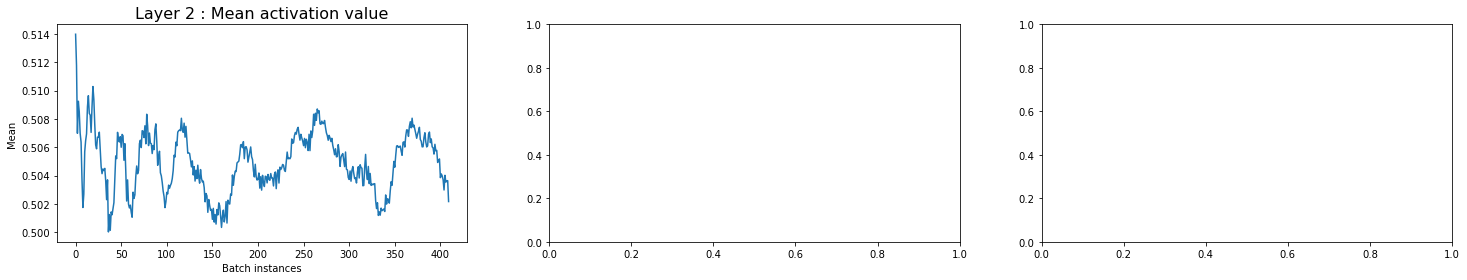

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(25, 4))

ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
ax[0].set_xlabel('Batch instances')
ax[0].set_ylabel('Mean')
ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])


In [51]:
df_stats_layer.shape[0]

410

In [ ]:
epoch = 3

running_loss = 0.0        
model.train()

for batch in train_loader:
    #inputs, labels = batch[0], batch[1]
    inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(-1).double())
        loss.backward()
        optimizer.step()

# update local train loss
    running_loss += loss.item() * inputs.size(0)

# update global train loss
epoch_loss = running_loss / len(train_loader.dataset)
print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

In [ ]:
#len(save_output_activation_stats.outputs)

In [ ]:
save_output_activation_stats

In [ ]:
pd.DataFrame(save_output_activation_stats[0].outputs)

In [ ]:
%%time
for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
    df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

    fig, ax = plt.subplots(1, 3, figsize=(25, 4))

    ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
    ax[0].set_xlabel('Batch instances')
    ax[0].set_ylabel('Mean')
    ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

    ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
    ax[1].set_xlabel('Batch instances')
    ax[1].set_ylabel('Standard deviation')
    ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

    ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
    ax[2].set_xlabel('Batch instances')
    ax[2].set_ylabel('Percentage')
    ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);